Usikkerheden fra støjen på sensoren bestemmes ved standardafvigelsen på målingerne fra nulmålingen.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.optimize import curve_fit
from scipy.stats import chisquare

# Filstier
nulmåling_loc = r"C:\Users\marcu\OneDrive\Documents\GitHub\MekRelLab\Lab 13 - Harmonisk oscillator\data\nulmåling_lab12.csv"
frimåling_loc = r"C:\Users\marcu\OneDrive\Documents\GitHub\MekRelLab\Lab 13 - Harmonisk oscillator\data\frimåling_lab12.csv"
luftmodstandsmåling_loc = r"C:\Users\marcu\OneDrive\Documents\GitHub\MekRelLab\Lab 13 - Harmonisk oscillator\data\luftmodstandmåling_lab12.csv"
skinnemåling_loc = r"C:\Users\marcu\OneDrive\Documents\GitHub\MekRelLab\Lab 13 - Harmonisk oscillator\data\skinnemåling_lab12.csv"

# Indlæs data
# [s] og [V]
nulmåling = np.genfromtxt(nulmåling_loc, delimiter=",", skip_header=1)
nulmåling_t_arr = nulmåling[:, 0]
nulmåling_v_arr = nulmåling[:, 1]

frimåling = np.genfromtxt(frimåling_loc, delimiter=",", skip_header=1)
frimåling_t_arr = frimåling[:, 0]
frimåling_v_arr = frimåling[:, 1]

luftmodstandsmåling = np.genfromtxt(luftmodstandsmåling_loc, delimiter=",", skip_header=1)
luftmodstandsmåling_t_arr = luftmodstandsmåling[:, 0]
luftmodstandsmåling_v_arr = luftmodstandsmåling[:, 1]

skinnemåling = np.genfromtxt(skinnemåling_loc, delimiter=",", skip_header=1)
skinnemåling_t_arr = skinnemåling[:, 0]
skinnemåling_v_arr = skinnemåling[:, 1]

# Usikkerheden fra signalstøj er standardafvigelsen på vores nulmåling afrundet til første ciffer
# [V]
usikkerhed_signalstøj = round(np.std(nulmåling_v_arr), 3)
print(usikkerhed_signalstøj)

# Usikkerheden på tiden er 
# [s]
usikkerhed_t = 0.000125

0.005


Vi plotter vores data (eksklusive nulmålingen) for at se om der er punkter vi ikke skal tage med i fittet

Frimåling


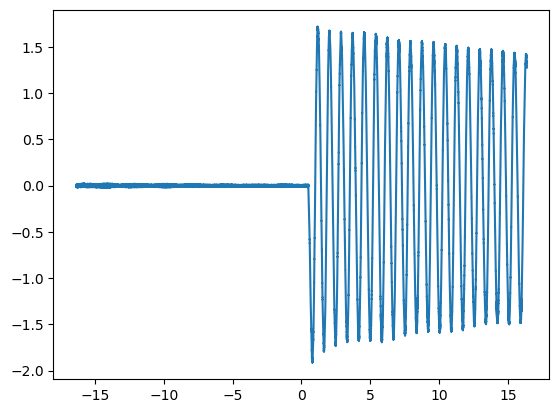

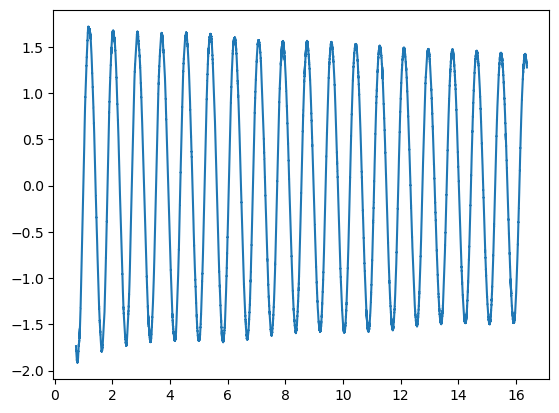

Skinnemåling


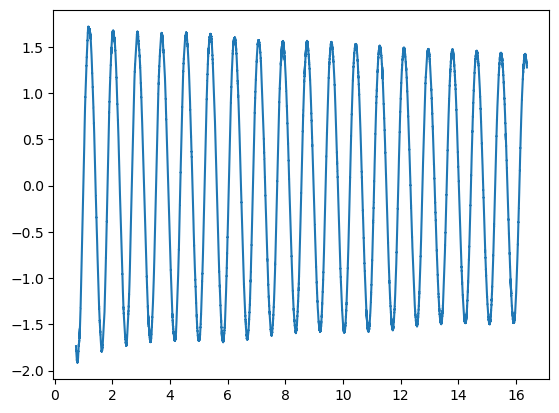

Luftmodstandsmåling


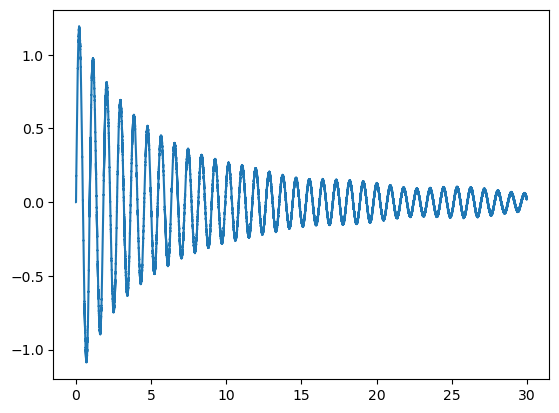

In [14]:
# Plot af data
print("Frimåling")
plt.figure(1)
plt.figsize = (10, 10)
plt.plot(frimåling_t_arr, frimåling_v_arr, label="Frimaling")
plt.show()

# Slet de første 140k punkter fra frimåling
frimåling_t_arr = frimåling_t_arr[137000:]
frimåling_v_arr = frimåling_v_arr[137000:]

plt.figure()
plt.figsize = (10, 10)
plt.plot(frimåling_t_arr, frimåling_v_arr, label="Frimaling")
plt.show()

print("Skinnemåling")
plt.figure()
plt.figsize = (10, 10)
plt.plot(frimåling_t_arr, frimåling_v_arr, label="Frimaling")
plt.show()

print("Luftmodstandsmåling")
plt.figure()
plt.figsize = (10, 10)
plt.plot(luftmodstandsmåling_t_arr, luftmodstandsmåling_v_arr, label="Frimaling")
plt.show()



Vi fitter diverse modeller til datasættet for den udæmpede oscillator.

Ingen dæmpning

In [15]:
def ingen_dæmp_func(t, A, omega, phi):
    return A*np.sin(omega*t + phi)

# Lav fittet
ingen_dæmp_startgæt = [1.5, 7.8, 5.12885193]
ingen_dæmp_param, ingen_dæmp_cov = curve_fit(ingen_dæmp_func, frimåling_t_arr, frimåling_v_arr, sigma=np.ones(len(frimåling_t_arr))*usikkerhed_signalstøj, absolute_sigma=True, p0=ingen_dæmp_startgæt)

# Tilføj propageret usikkerhed fra tiden til positionen
A, omega, phi = ingen_dæmp_param

ingen_dæmp_sigma = np.sqrt(np.diagonal(ingen_dæmp_cov))
ingen_dæmp_sigma_prop_u = [(-A*omega*np.sin(omega*t - phi))*usikkerhed_t + usikkerhed_signalstøj for t in frimåling_t_arr]

# Gentag fittet med den propagerede usikkerhed
ingen_dæmp_param, ingen_dæmp_cov = curve_fit(ingen_dæmp_func, frimåling_t_arr, frimåling_v_arr, sigma=ingen_dæmp_sigma_prop_u, absolute_sigma=True, p0=ingen_dæmp_startgæt)

ingen_dæmp_chi_red = np.sum(((frimåling_v_arr - ingen_dæmp_func(frimåling_t_arr, *ingen_dæmp_param))/ingen_dæmp_sigma_prop_u)**2)/(len(frimåling_t_arr) - len(ingen_dæmp_param))

chi_0 = np.sum((frimåling_v_arr - ingen_dæmp_func(frimåling_t_arr, *ingen_dæmp_param))**2 / 0.005**2)
chi2_red = chi_0 / (len(frimåling_v_arr - len(ingen_dæmp_param)))

print("Parametre")
print(ingen_dæmp_param)
print("Chi^2 red")
print(chi2_red)

Parametre
[-1.59693824  7.47811659  8.22444392]
Chi^2 red
325.7924517947898


Linær dæmpning

In [16]:
def lin_dæmp_func(t, A_0, D, omega, phi):
    return (-1.8 - D*t)*np.sin(omega*t + phi)

# Lav fittet
lin_dæmp_startgæt = [-1.8, -0.09077228, 9.9168077, 2.63312925]

lin_dæmp_param, lin_dæmp_cov = curve_fit(lin_dæmp_func, frimåling_t_arr, frimåling_v_arr, sigma=np.ones(len(frimåling_t_arr))*usikkerhed_signalstøj, absolute_sigma=True ,p0=lin_dæmp_startgæt, maxfev=100000)

# Tilføj propageret usikkerhed fra tiden til positionen
A_0, D, omega, phi = lin_dæmp_param

lin_dæmp_sigma = np.sqrt(np.diagonal(lin_dæmp_cov))
lin_dæmp_sigma_prop_u = [(-D - (A_0 - D*t)*omega*np.sin(omega*t - phi))*usikkerhed_t + usikkerhed_signalstøj for t in frimåling_t_arr]

# Gentag fittet med den propagerede usikkerhed
lin_dæmp_param, lin_dæmp_cov = curve_fit(lin_dæmp_func, frimåling_t_arr, frimåling_v_arr, sigma=lin_dæmp_sigma_prop_u, absolute_sigma=True, p0=lin_dæmp_startgæt, maxfev=100000)

# Udregn reduceret chi^2
lin_dæmp_chi_red = np.sum(((frimåling_v_arr - lin_dæmp_func(frimåling_t_arr, *lin_dæmp_param))/lin_dæmp_sigma_prop_u)**2)/(len(frimåling_t_arr) - len(lin_dæmp_param))

print("Parametre")
print(lin_dæmp_param)
print("Chi^2 red")
print(lin_dæmp_chi_red)

Parametre
[-1.8        -0.17326393  9.85714604  5.37699454]
Chi^2 red
63243.37037701172


Eksponentiel dæmpning

In [17]:
def exp_dæmp_func(t, A_0, D, omega, phi):
    return (A_0*np.exp(-D*t))*np.sin(omega*t + phi)

# Lav fittet
exp_dæmp_startgæt = [-1.5, 1, 7.48253038, 1]
exp_dæmp_param, exp_dæmp_cov = curve_fit(exp_dæmp_func, frimåling_t_arr, frimåling_v_arr, sigma=np.ones(len(frimåling_t_arr))*usikkerhed_signalstøj, absolute_sigma=True, p0=exp_dæmp_startgæt)

# Tilføj propageret usikkerhed fra tiden til positionen
A_0, D, omega, phi = exp_dæmp_param

exp_dæmp_sigma = np.sqrt(np.diagonal(exp_dæmp_cov))
exp_dæmp_sigma_prop_u = [(-D*t*A_0*np.exp(-D*t) - A_0*np.exp(-D*t)*np.sin(omega*t - phi))*usikkerhed_t + usikkerhed_signalstøj for t in frimåling_t_arr]

# Gentag fittet med den propagerede usikkerhed
exp_dæmp_param, exp_dæmp_cov = curve_fit(exp_dæmp_func, frimåling_t_arr, frimåling_v_arr, sigma=exp_dæmp_sigma_prop_u, absolute_sigma=True, p0=exp_dæmp_startgæt)

# Udregn reduceret chi^2
exp_dæmp_chi_red = np.sum(((frimåling_v_arr - exp_dæmp_func(frimåling_t_arr, *exp_dæmp_param))/exp_dæmp_sigma_prop_u)**2)/(len(frimåling_t_arr) - len(exp_dæmp_param))

print("Parametre")
print(exp_dæmp_param)
print("Chi^2 red")
print(exp_dæmp_chi_red)


Parametre
[-1.75272774  0.01248385  7.47702057  1.95770671]
Chi^2 red
154.24444580691755


Vi plotter fitsne sammen med vores data for den udæmpede oscillator

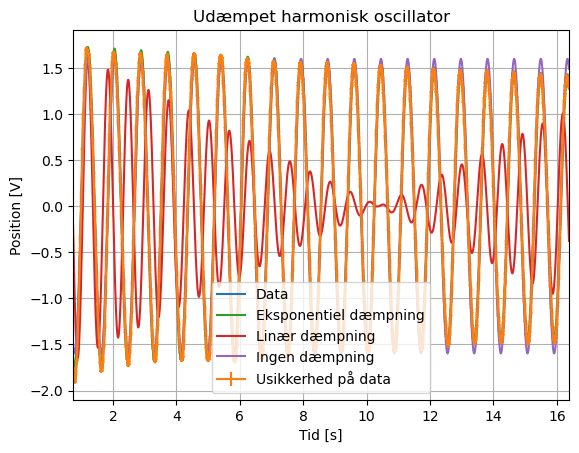

In [18]:

plt.figure(1)
plt.grid()
plt.xlabel("Tid [s]")
plt.ylabel("Position [V]")
plt.title("Udæmpet harmonisk oscillator")

# Plot af data
plt.plot(frimåling_t_arr, frimåling_v_arr, label="Data")
plt.errorbar(frimåling_t_arr, frimåling_v_arr, xerr=usikkerhed_t, yerr=usikkerhed_signalstøj, label="Usikkerhed på data")

# Plot af fits
plt.plot(frimåling_t_arr, exp_dæmp_func(frimåling_t_arr, *exp_dæmp_param), label="Eksponentiel dæmpning")
plt.plot(frimåling_t_arr, lin_dæmp_func(frimåling_t_arr, *lin_dæmp_param), label="Linær dæmpning")
plt.plot(frimåling_t_arr, ingen_dæmp_func(frimåling_t_arr, *ingen_dæmp_param), label="Ingen dæmpning")
plt.gca().set_xlim([min(frimåling_t_arr), max(frimåling_t_arr)])
plt.legend()
plt.show()


### Residualer

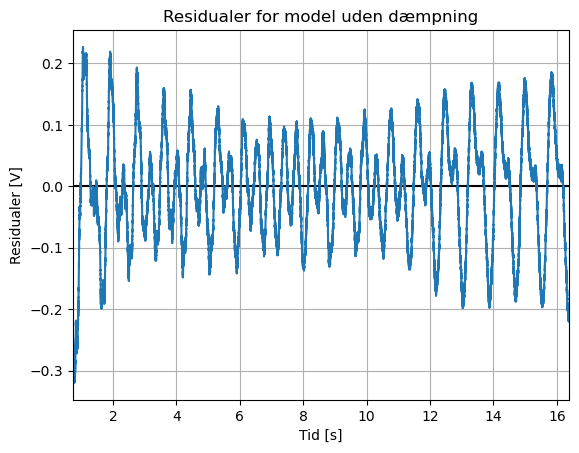

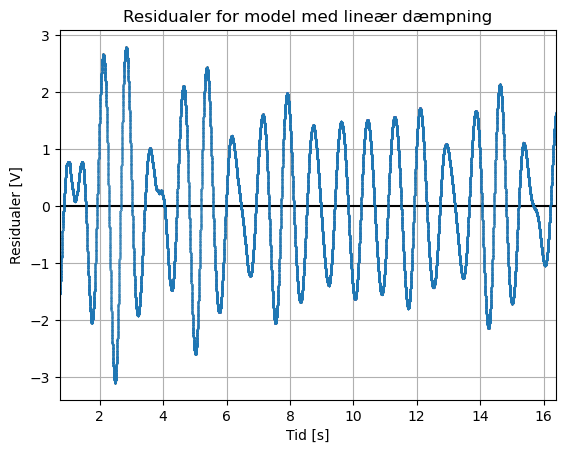

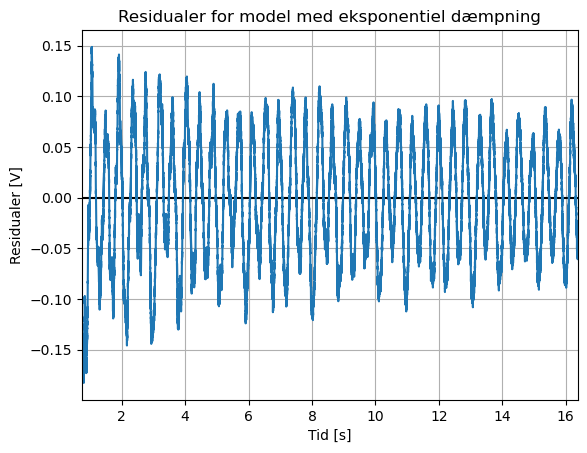

In [39]:
# Find residualer for modellen uden dæmpning

X = frimåling_t_arr
Y = [frimåling_v_arr[i] - ingen_dæmp_func(frimåling_t_arr[i], *ingen_dæmp_param) for i in range(len(frimåling_t_arr))]

plt.figure(2)
plt.grid()
plt.xlabel("Tid [s]")
plt.ylabel("Residualer [V]")
plt.title("Residualer for model uden dæmpning")

plt.axhline(y=0, color="black")

plt.plot(X, Y)
plt.gca().set_xlim([min(X), max(X)])
plt.show()

# Find residualer for modellem med lineær dæmpning

X = frimåling_t_arr
Y = [frimåling_v_arr[i] - lin_dæmp_func(frimåling_t_arr[i], *lin_dæmp_param) for i in range(len(frimåling_t_arr))]

plt.figure(3)
plt.grid()
plt.xlabel("Tid [s]")
plt.ylabel("Residualer [V]")
plt.title("Residualer for model med lineær dæmpning")

plt.axhline(y=0, color="black")

plt.plot(X, Y, linestyle='None', marker='.', markersize=0.2)
plt.gca().set_xlim([min(X), max(X)])
plt.savefig("frimåling_lin_residualer.jpg", dpi=1000)
plt.show()

# Find residualer for modellen med eksponentiel dæmpning

X = frimåling_t_arr
Y = [frimåling_v_arr[i] - exp_dæmp_func(frimåling_t_arr[i], *exp_dæmp_param) for i in range(len(frimåling_t_arr))]

plt.figure(4)
plt.grid()
plt.xlabel("Tid [s]")
plt.ylabel("Residualer [V]")
plt.title("Residualer for model med eksponentiel dæmpning")

plt.axhline(y=0, color="black")

plt.plot(X, Y)
plt.gca().set_xlim([min(X), max(X)])
plt.show()




### Ingen + exp

In [20]:
def ioexp_dæmp_func(t, A_1, omega_1, phi_1, A_2, D, omega_2, phi_2):
    return A_1*np.sin(omega_1*t + phi_1) + (A_2*np.exp(-D*t))*np.sin(omega_2*t + phi_2)  
    
# Lav fittet
ioexp_dæmp_startgæt = [1.5, 1, 0, -1.8, 1, 1, 0]
ioexp_dæmp_param, ioexp_dæmp_cov = curve_fit(ioexp_dæmp_func, frimåling_t_arr, frimåling_v_arr, sigma=np.ones(len(frimåling_t_arr))*usikkerhed_signalstøj, absolute_sigma=True, p0=ioexp_dæmp_startgæt)

# Udregn reduceret chi^2
from scipy.stats import chisquare

X = frimåling_v_arr
Y = ioexp_dæmp_func(frimåling_t_arr, *ioexp_dæmp_param)

chi2, p = chisquare(X, Y)
dof = len(X) - len(ioexp_dæmp_param)

reduced_chi2 = chi2/dof

print(reduced_chi2)


ioexp_dæmp_chi_red = np.sum(((frimåling_v_arr - ioexp_dæmp_func(frimåling_t_arr, *ioexp_dæmp_param))/np.ones(len(frimåling_t_arr))*usikkerhed_signalstøj)**2)/(len(frimåling_t_arr) - len(ioexp_dæmp_param))

print("Parametre")
print(ioexp_dæmp_param)
print("Chi^2 red")
print(ioexp_dæmp_chi_red)



0.00014205181941176072
Parametre
[-3.26093358e-03  1.00443163e+00  6.87486102e-01 -1.74830373e+00
  1.24041627e-02  7.47696295e+00 -4.32389941e+00]
Chi^2 red
9.627021609292999e-08


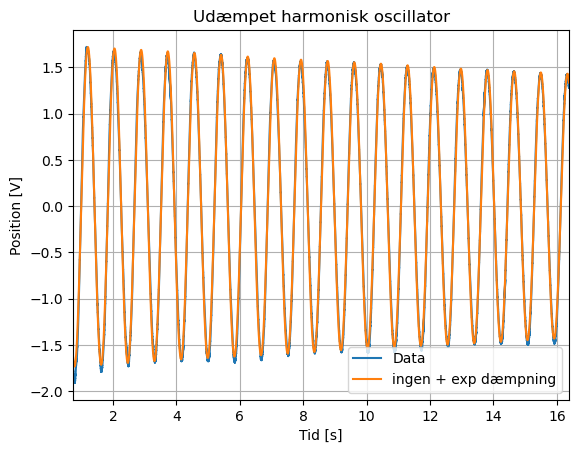

In [21]:
plt.figure(5)
plt.grid()
plt.xlabel("Tid [s]")
plt.ylabel("Position [V]")
plt.title("Udæmpet harmonisk oscillator")

# Plot af data
plt.plot(frimåling_t_arr, frimåling_v_arr, label="Data")
#plt.errorbar(frimåling_t_arr, frimåling_v_arr, xerr=usikkerhed_t, yerr=usikkerhed_signalstøj, label="Usikkerhed på data")

# Plot af fits
plt.plot(frimåling_t_arr, ioexp_dæmp_func(frimåling_t_arr, *ioexp_dæmp_param), label="ingen + exp dæmpning")
plt.gca().set_xlim([min(frimåling_t_arr), max(frimåling_t_arr)])
plt.legend()
plt.show()




### Ingen + Lin

In [22]:
def iolin_dæmp_func(t, A_1, omega_1, phi_1, A_2, D, omega_2, phi_2):
    return A_1*np.sin(omega_1*t + phi_1) + (-1.8 - D*t)*np.sin(omega_2*t + phi_2)

# Lav fittet
iolin_dæmp_startgæt = [-15, 8, 1, -1, -1.5, 10, 2]
iolin_dæmp_param, iolin_dæmp_cov = curve_fit(iolin_dæmp_func, frimåling_t_arr, frimåling_v_arr, sigma=np.ones(len(frimåling_t_arr))*usikkerhed_signalstøj, absolute_sigma=True, p0=iolin_dæmp_startgæt, maxfev = 10000)

# Udregn reduceret chi^2
iolin_dæmp_chi_red = np.sum(((frimåling_v_arr - iolin_dæmp_func(frimåling_t_arr, *iolin_dæmp_param))/np.ones(len(frimåling_t_arr))*usikkerhed_signalstøj)**2)/(len(frimåling_t_arr) - len(iolin_dæmp_param))

print("Parametre")
print(iolin_dæmp_param)
print("Chi^2 red")
print(iolin_dæmp_chi_red)



Parametre
[-0.36919139  8.08073304 -0.09086763 -1.         -0.17117283 10.24448131
 -1.35734535]
Chi^2 red
3.563712332206801e-05


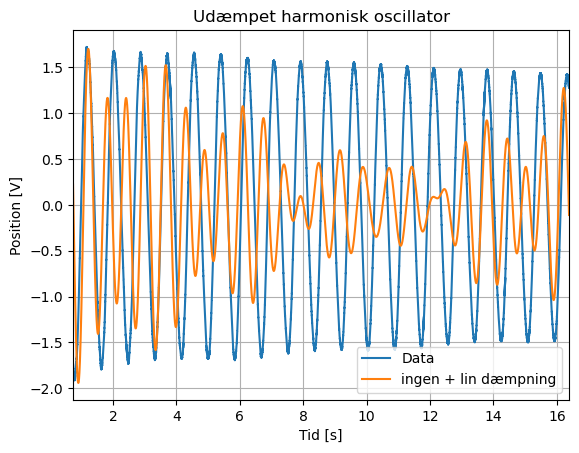

In [23]:
plt.figure(6)
plt.grid()
plt.xlabel("Tid [s]")
plt.ylabel("Position [V]")
plt.title("Udæmpet harmonisk oscillator")

# Plot af data
plt.plot(frimåling_t_arr, frimåling_v_arr, label="Data")
#plt.errorbar(frimåling_t_arr, frimåling_v_arr, xerr=usikkerhed_t, yerr=usikkerhed_signalstøj, label="Usikkerhed på data")

# Plot af fits
plt.plot(frimåling_t_arr, iolin_dæmp_func(frimåling_t_arr, *iolin_dæmp_param), label="ingen + lin dæmpning")
plt.gca().set_xlim([min(frimåling_t_arr), max(frimåling_t_arr)])
plt.legend()
plt.show()


### 4 x ingen dæmpning

In [24]:
def i_4_dæmp_func(t, A_1, omega_1, phi_1, A_2, omega_2, phi_2, A_3, omega_3, phi_3, A_4, omega_4, phi_4,):
    return A_1*np.sin(omega_1*t + phi_1) + A_2*np.sin(omega_2*t + phi_2) + A_3*np.sin(omega_3*t + phi_3) + A_4*np.sin(omega_4*t + phi_4)

# Lav fittet
i_4_dæmp_startgæt = []

for i in range(4):
    i_4_dæmp_startgæt.append(ingen_dæmp_param[0])
    i_4_dæmp_startgæt.append(ingen_dæmp_param[1])
    i_4_dæmp_startgæt.append(ingen_dæmp_param[2])

i_4_dæmp_param, i_4_dæmp_cov = curve_fit(i_4_dæmp_func, frimåling_t_arr, frimåling_v_arr, sigma=np.ones(len(frimåling_t_arr))*usikkerhed_signalstøj, absolute_sigma=True, p0=i_4_dæmp_startgæt, maxfev = 10000)

# Udregn reduceret chi^2
#i_4_dæmp_chi_red = np.sum(((frimåling_v_arr - i_4_dæmp_func(frimåling_t_arr, *i_4_dæmp_param))/np.ones(len(frimåling_t_arr))*usikkerhed_signalstøj)**2)/(len(frimåling_t_arr) - len(i_4_dæmp_param))

chi_0 = np.sum((frimåling_v_arr - ingen_dæmp_func(frimåling_t_arr, *ingen_dæmp_param))**2 / 0.005**2)
chi2_red = chi_0 / (len(frimåling_v_arr - len(i_4_dæmp_param)))

print("Parametre")
print(i_4_dæmp_param)
print("Chi^2 red")
print(chi2_red)


Parametre
[ 1.6380468   7.30592498  7.40877883  0.58013789  7.46262306  7.79264095
 -2.31115531  7.46258836  8.33194528 -1.99230651  7.3203306   7.2689103 ]
Chi^2 red
325.7924517947898


In [25]:
def chi2_red(data, model_data, param):
        chi2 = 0
        for i in range(len(data)):
            chi2 += (data[i] - model_data[i])**2/(usikkerhed_signalstøj**2)

        return chi2/(len(data) - len(param))

print(chi2_red(frimåling_v_arr, [i_4_dæmp_func(t, *i_4_dæmp_param) for t in frimåling_t_arr], i_4_dæmp_param))

150.63918344072735


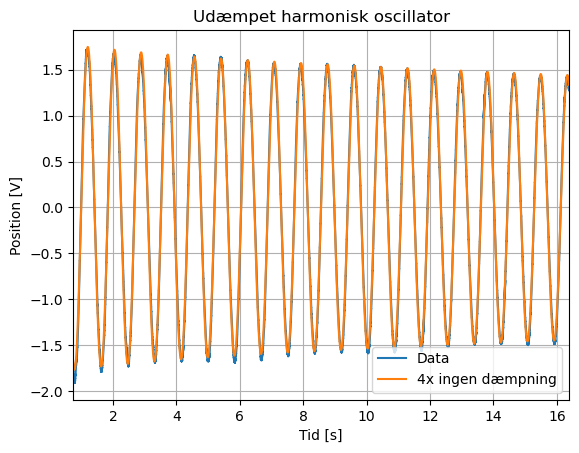

In [26]:
plt.figure(7)
plt.grid()
plt.xlabel("Tid [s]")
plt.ylabel("Position [V]")
plt.title("Udæmpet harmonisk oscillator")

# Plot af data
plt.plot(frimåling_t_arr, frimåling_v_arr, label="Data")
#plt.errorbar(frimåling_t_arr, frimåling_v_arr, xerr=usikkerhed_t, yerr=usikkerhed_signalstøj, label="Usikkerhed på data")

# Plot af fits
plt.plot(frimåling_t_arr, i_4_dæmp_func(frimåling_t_arr, *i_4_dæmp_param), label="4x ingen dæmpning")
plt.gca().set_xlim([min(frimåling_t_arr), max(frimåling_t_arr)])
plt.legend()
plt.show()


In [27]:
def exp_4_dæmp_func(t, A_1, D_1, omega_1, phi_1, A_2, D_2, omega_2, phi_2, A_3, D_3, omega_3, phi_3, A_4, D_4, omega_4, phi_4):
    return (A_1*np.exp(-D_1*t))*np.sin(omega_1*t + phi_1) + (A_2*np.exp(-D_2*t))*np.sin(omega_2*t + phi_2) + (A_3*np.exp(-D_3*t))*np.sin(omega_3*t + phi_3) + (A_4*np.exp(-D_4*t))*np.sin(omega_4*t + phi_4)
    
# Lav fittet

ioexp_dæmp_param, ioexp_dæmp_cov = curve_fit(exp_4_dæmp_func, frimåling_t_arr, frimåling_v_arr, sigma=np.ones(len(frimåling_t_arr))*usikkerhed_signalstøj, absolute_sigma=True)

# Udregn reduceret chi^2
from scipy.stats import chisquare

X = frimåling_v_arr
Y = exp_4_dæmp_func(frimåling_t_arr, *ioexp_dæmp_param)

chi2, p = chisquare(X, Y)
dof = len(X) - len(ioexp_dæmp_param)

reduced_chi2 = chi2/dof

print(reduced_chi2)


ioexp_dæmp_chi_red = np.sum(((frimåling_v_arr - exp_4_dæmp_func(frimåling_t_arr, *ioexp_dæmp_param))/np.ones(len(frimåling_t_arr))*usikkerhed_signalstøj)**2)/(len(frimåling_t_arr) - len(ioexp_dæmp_param))

print("Parametre")
print(ioexp_dæmp_param)
print("Chi^2 red")
print(ioexp_dæmp_chi_red)



C:\Users\marcu\AppData\Local\Temp\ipykernel_15380\1767771457.py:2: RuntimeWarning: overflow encountered in exp
  return (A_1*np.exp(-D_1*t))*np.sin(omega_1*t + phi_1) + (A_2*np.exp(-D_2*t))*np.sin(omega_2*t + phi_2) + (A_3*np.exp(-D_3*t))*np.sin(omega_3*t + phi_3) + (A_4*np.exp(-D_4*t))*np.sin(omega_4*t + phi_4)
C:\Users\marcu\AppData\Local\Temp\ipykernel_15380\1767771457.py:2: RuntimeWarning: overflow encountered in multiply
  return (A_1*np.exp(-D_1*t))*np.sin(omega_1*t + phi_1) + (A_2*np.exp(-D_2*t))*np.sin(omega_2*t + phi_2) + (A_3*np.exp(-D_3*t))*np.sin(omega_3*t + phi_3) + (A_4*np.exp(-D_4*t))*np.sin(omega_4*t + phi_4)
c:\Users\marcu\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:504: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


-0.0002614598174864121
Parametre
[-4.41286213e+00  8.64927011e-01  7.46967306e+00 -7.92879640e+00
 -5.07043220e+00  1.00541025e+00  7.44658342e+00 -4.74573107e+00
 -4.09138296e+00  7.22850091e-03  7.44972173e+00 -3.20395308e+00
 -3.70383118e+00  2.03536382e-02  7.44211188e+00 -5.87668807e+00]
Chi^2 red
8.706150664873057e-08
